In [34]:
from dotenv import load_dotenv

load_dotenv()

True

In [35]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///../../Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [36]:
from langchain.chat_models import init_chat_model

# llm = init_chat_model("openai:gpt-4o-mini")
llm = init_chat_model("openai:gpt-4.1")

In [37]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.tools.sql_database.tool import (
    InfoSQLDatabaseTool,
    ListSQLDatabaseTool,
    QuerySQLCheckerTool,
    QuerySQLDatabaseTool,
)

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()
list_tables_tool = next(tool for tool in tools if isinstance(tool, ListSQLDatabaseTool))
get_related_schema_tool = next(
    tool for tool in tools if isinstance(tool, InfoSQLDatabaseTool)
)
check_sql_tool = next(tool for tool in tools if isinstance(tool, QuerySQLCheckerTool))
execute_sql_tool = next(
    tool for tool in tools if isinstance(tool, QuerySQLDatabaseTool)
)
print(
    list_tables_tool.name,
    get_related_schema_tool.name,
    check_sql_tool.name,
    execute_sql_tool.name,
)

sql_db_list_tables sql_db_schema sql_db_query_checker sql_db_query


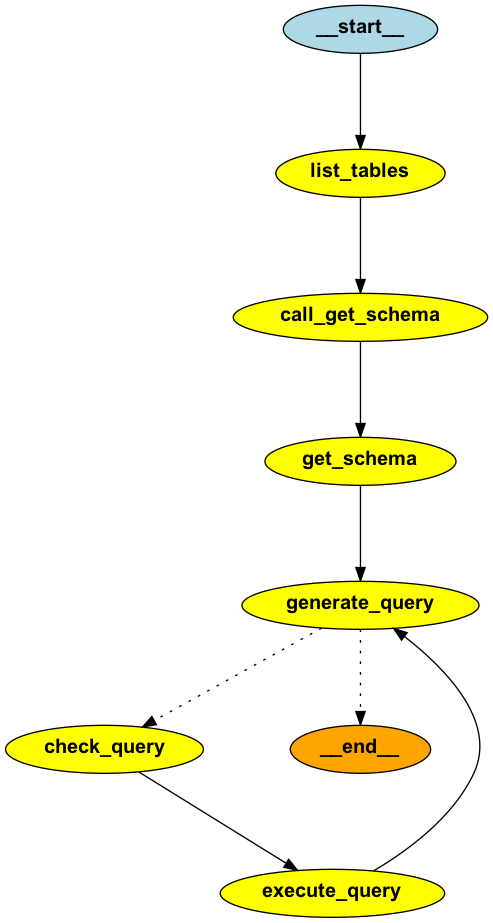

In [63]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage
from langchain_core.messages.tool import ToolCall
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, START, StateGraph
from typing import Literal
from IPython.display import Image, display
import uuid


def list_tables(state: MessagesState):
    tool_call = ToolCall(
        name=list_tables_tool.name,
        args={},
        id=str(uuid.uuid4()),
        type="tool_call",
    )
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}


def call_get_schema(state: MessagesState):
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = llm.bind_tools([get_related_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


get_schema_node = ToolNode([get_related_schema_tool], name="get_schema")

generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=5,
)


def generate_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = llm.bind_tools([execute_sql_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}


def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "check_query"


check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(
    dialect=db.dialect
)


def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = llm.bind_tools([execute_sql_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}


execute_query_node = ToolNode([execute_sql_tool], name="execute_query")

graph_builder = StateGraph(MessagesState).add_sequence(
    [
        list_tables,
        call_get_schema,
        get_schema_node,
        generate_query,
    ]
)
graph_builder.add_sequence(
    [
        check_query,
        execute_query_node,
    ]
)
graph_builder.add_edge(START, "list_tables")
graph_builder.add_conditional_edges("generate_query", should_continue)
graph_builder.add_edge("execute_query", "generate_query")
agent = graph_builder.compile()

display(Image(agent.get_graph().draw_png()))

In [65]:
from langchain_core.messages import HumanMessage

for step in agent.stream(
    {"messages": [HumanMessage("What artist has the largest number of albums?")]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What artist has the largest number of albums?
================================== Ai Message ==================================

Available tables: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_jzNzMQbu8VvS7azdCqWAOVny)
 Call ID: call_jzNzMQbu8VvS7azdCqWAOVny
  Args:
    table_names: Album, Artist
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")
)

/*
3 rows from Album table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
